In [178]:
import json
import math
import re
import numpy as np
import pandas as pd

In [179]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance in meters between two points 
    on the Earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of Earth in meters (mean radius = 6,371km)
    r = 6371000
    return c * r


In [180]:
def filter_by_radius(df, ref_lat, ref_lon, radius_km=5.0,max_speed = 10):
    """
    Filters DataFrame to rows within a specified radius (km) of a reference point.
    
    Args:
        df: DataFrame with 'latitude' and 'longitude' columns
        ref_lat: Reference latitude (center point)
        ref_lon: Reference longitude (center point)
        radius_km: Radius in kilometers (default: 5.0 km)
        
    Returns:
        Filtered DataFrame with added 'distance_km' column
    """
    # Calculate distance for each row
    low_speed_df = df[df['speed'] < max_speed].copy()
    
    # Calculate distance for remaining points
    low_speed_df['distance_km'] = low_speed_df.apply(
        lambda row: haversine(ref_lat, ref_lon, row['latitude'], row['longitude']),
        axis=1
    )
    
    # Filter rows within radius
    filtered_df = low_speed_df[low_speed_df['distance_km'] <= radius_km].copy()
    
    return filtered_df

In [181]:
caseid = '23608578' 
prefix = caseid + '/' + caseid

In [182]:
with open(prefix +'_validations.geojson', 'r') as f:
    geojson_data = json.load(f)
with open(prefix +'_full_topology_data.geojson', 'r') as f:
    topojson_data = json.load(f)
with open(prefix +'_signs.geojson', 'r') as f:
    signjson_data = json.load(f)

probedf = pd.read_csv(prefix +'_probe_data.csv')

In [183]:
def coordcheck(c1s,c2,distance_threshold):
    for c1 in c1s:
        distance = haversine(c1[0],c1[1],c2[0],c2[1])
        if distance < distance_threshold:
            return [True, [c1[0],c1[1]]]
    return [False, []]

In [184]:
for i in range(0,len(geojson_data['features'])):
    signid = geojson_data['features'][i]['properties']['Feature ID']
    ermes = geojson_data['features'][i]['properties']['Error Message']
    topo = re.search(r'urn:here::here:Topology:(\d+)', ermes).group(0)
    print(i)
    print(geojson_data['features'][i])
    for j in range(0,len(signjson_data['features'])):
        c2 = signjson_data['features'][j]['properties']['id']
        if signjson_data['features'][j]['properties']['signType'] == 'MOTORWAY' and signid == c2:
            print(signjson_data['features'][j]['properties'])
            print(j)
    for x in range(0,len(topojson_data['features'])):
        c3 = topojson_data['features'][x]['properties']['id']
        if topo == c3:
            print(topojson_data['features'][x]['properties'])
            print(x)

0
{'type': 'Feature', 'properties': {'Rule Code': 'WSIGN406', 'Feature ID': 'urn:here::here:signs:1622369191769486075', 'Feature Type': 'Road Sign', 'Error Message': 'Motorway Sign urn:here::here:signs:1622369191769486075 at Lat 9.92431077 Lon 53.59518736 is associated to a Topology urn:here::here:Topology:904275331 that has a range for Pedestrian = TRUE within 20m distance.', 'Status': 'ACTIVE', 'LE Allowed': False, 'Clean for Extract': False, 'Partition ID': 23608578, 'ISO': 'DEU', 'Violation ID': 'urn:here::here:Violation:signs-f2cf7fef-5a4b-36cd-b9d8-d195ac505c7e', 'is_within': True}, 'geometry': {'type': 'Point', 'coordinates': [9.92431, 53.59519]}}
{'partition_id': '23608578', 'id': 'urn:here::here:signs:1622369191769486075', 'widthCm': {'dimensionCm': 104}, 'heightCm': {'dimensionCm': 92}, 'signType': 'MOTORWAY', 'signValue': '', 'confidence': {'simpleScores': [{'score': 0.8231715044244745, 'sources': ['BMW_RSD'], 'scoreType': 'EXISTENCE', 'featureType': 'SIGN_EXISTENCE', 'posit

In [185]:
def computefacing(quat):
    w, x, y, z = quat['w'], quat['x'], quat['y'], quat['z']
    
    # Calculate forward vector
    forward = np.array([
        2 * (x*z + w*y),      # East-West (X)
        2 * (y*z - w*x),      # North-South (Y) 
        1 - 2 * (x*x + y*y)   # Up-Down (Z)
    ])
    forward /= np.linalg.norm(forward)
    
    # Calculate bearing (0°=North, 90°=East)
    bearing = np.degrees(np.arctan2(forward[0], forward[1])) % 360
    return bearing

In [186]:
signcord = geojson_data['features'][0]['geometry']['coordinates']
face =  signjson_data['features'][0]['properties']['orientation']['orientation']

[9.92411, 53.59507]
(30, 9)
not highway
True
[9.92411, 53.59507]
(30, 9)
not highway
True
[9.9241312, 53.5952892]
(29, 9)
not highway
True
[9.92411, 53.59507]
(30, 9)
not highway
False
[9.92444, 53.59512]
(18, 9)
not highway
False
[9.9244333, 53.5950521]
(18, 9)
not highway
True
[9.92411, 53.59507]
(30, 9)
not highway
True


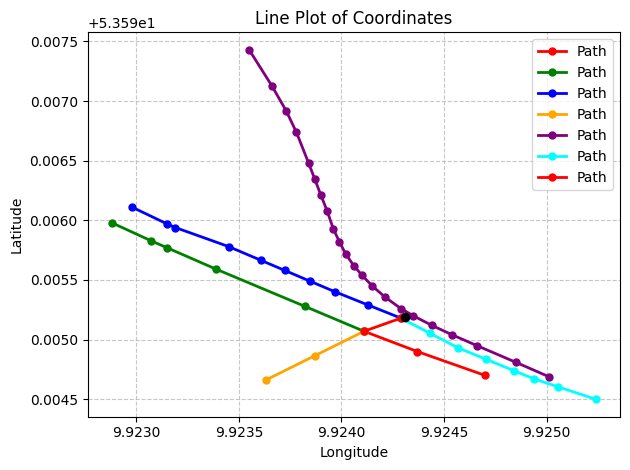

In [192]:
import matplotlib.pyplot as plt
from itertools import cycle
color_cycle = cycle(['red', 'green', 'blue', 'orange', 'purple', 'cyan'])

for i in range(0,len(topojson_data['features'])):
    condition, coord = coordcheck(topojson_data['features'][i]['geometry']['coordinates'],signcord,20)
    if condition:
        coordinates = topojson_data['features'][i]['geometry']['coordinates']
        filtered_probedf= filter_by_radius(probedf,coord[1],coord[0],20,1)
        print(coord)
        print(filtered_probedf.shape)
        if (filtered_probedf['speed'] < 10).any():
            print('not highway')
        else:
            print('highway')
        print(topojson_data['features'][i]['properties']['accessCharacteristics'][0]['pedestrian'])
        # Unzip coordinates into separate X and Y lists
        x, y = zip(*coordinates)  # Unpack tuples into two lists

        # Plot
        plt.plot(x, y, 
                color=next(color_cycle),
                marker='o',      # Add markers at each point
                linestyle='-',   # Solid line
                linewidth=2,     # Thicker line
                markersize=5,    # Size of markers
                label='Path')
coordinates = topojson_data['features'][676]['geometry']['coordinates']
x, y = zip(*coordinates)
# plt.plot(x, y, 
#                 color='yellow', 
#                 marker='o',      # Add markers at each point
#                 linestyle='-',   # Solid line
#                 linewidth=2,     # Thicker line
#                 markersize=5,    # Size of markers
#                 label='asscoiated')
plt.plot(signcord[0],signcord[1],color='black',marker='o')
# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Line Plot of Coordinates')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [188]:
file_path = 'data.json'

with open(file_path, 'w') as json_file:
    json.dump(signjson_data['features'][477], json_file, indent=4)